In [1]:
# ---------------- IMPORT LIBRARIES ---------------- #
import os
import numpy as np
import pandas as pd
import pickle
import cv2
import time
import joblib

In [2]:
from tensorflow.keras.models import load_model

model_path = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\best_model.keras"
model = load_model(model_path)


In [3]:
import pandas as pd
import numpy as np

data = joblib.load(r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\final_dataOG.pkl")
raw_data=pd.read_pickle(r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\cleaned_data\train_data_cleaned.pkl")



In [4]:
# Extract actual amount values
actual_amounts = raw_data["Amount"].values  # Ensure this column exists

In [5]:
# Extract structured data (already encoded & scaled)
# Extract first 18 columns, excluding columns 1, 6, and 7
structured_data = data.iloc[:, :18]  # First 18 columns
structured_data = structured_data.drop(columns=[data.columns[0], data.columns[5], data.columns[6]])
structured_data_scaled = structured_data.values

In [6]:
# Extract image amounts
image_features = data.iloc[:, 18:].values

In [7]:
# Extract labels
condition_labels = data['Condition'].values  # Binary classification target
amount_labels = data['Amount'].values.reshape(-1, 1)  # Regression target

In [8]:
print("Image amounts Shape:", image_features.shape)
print("Structured Data Shape:", structured_data_scaled.shape)
print("Model Input Shape:", model.input_shape)

Image amounts Shape: (1310, 2048)
Structured Data Shape: (1310, 15)
Model Input Shape: [(None, 2048), (None, 15)]


In [9]:
predictions = model.predict([image_features, structured_data_scaled])

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step  


In [10]:
predicted_condition = predictions[0]  # Classification output (0 or 1)
predicted_amount = predictions[1]  # Regression output (continuous value)

In [11]:
print("Predicted Conditions:", predicted_condition[:5])  # First 5 values
print("Predicted Amounts:", predicted_amount[:5])  # First 5 values

Predicted Conditions: [[5.8634934e-04]
 [9.9759322e-01]
 [4.3217599e-04]
 [9.9839312e-01]
 [9.9735940e-01]]
Predicted Amounts: [[-2.9042025 ]
 [ 0.42111748]
 [-3.0422556 ]
 [ 0.52841526]
 [ 0.48568135]]


In [12]:
predicted_amount.shape

(1310, 1)

In [13]:
amount_SCALER_PATH = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\scalers\amount_scaler.pkl"

In [14]:
if not os.path.exists(amount_SCALER_PATH):
    raise FileNotFoundError(f"Scaler file not found: {amount_SCALER_PATH}")
    
with open(amount_SCALER_PATH, "rb") as f:
        amount_scaler = joblib.load(f)

In [15]:
import numpy as np

# Convert condition output to binary (0 or 1)
predicted_condition_binary = (predicted_condition.flatten() > 0.5).astype(int)

print("Predicted Amounts (raw):", predicted_amount[:10])

# Reverse scaling for amount
predicted_amount_original = amount_scaler.inverse_transform(predicted_amount.reshape(-1, 1)).flatten()

# Reverse log transformation (if applicable)
predicted_amount_final = np.expm1(predicted_amount_original)  # Apply expm1 AFTER inverse transform

# Apply condition: If predicted_condition_binary == 0, amount should be 0
predicted_amount_final = np.where(predicted_condition_binary == 0, 0, predicted_amount_final)

# Print sample results
print("Predicted Conditions (binary):", predicted_condition_binary[:10])
print("Final Predicted Amounts:", predicted_amount_final[:10])


Predicted Amounts (raw): [[-2.9042025 ]
 [ 0.42111748]
 [-3.0422556 ]
 [ 0.52841526]
 [ 0.48568135]
 [ 0.04263787]
 [ 0.38736647]
 [ 0.29309672]
 [ 0.5560896 ]
 [ 0.3519644 ]]
Predicted Conditions (binary): [0 1 0 1 1 1 1 1 1 1]
Final Predicted Amounts: [   0.     4692.6875    0.     6007.8794 5444.868  1962.8079 4341.7896
 3494.548  6403.177  4001.8835]


In [16]:
print("Predicted Amount Shape:", predicted_amount_original.shape)

Predicted Amount Shape: (1310,)


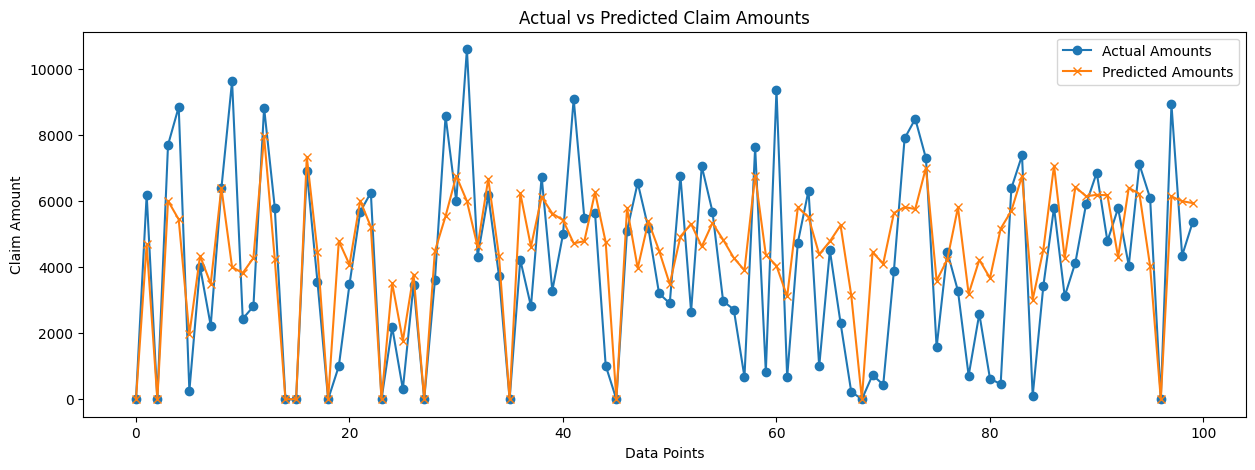

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(actual_amounts[:100], label="Actual Amounts", marker='o')  # First 50 points
plt.plot(predicted_amount_final[:100], label="Predicted Amounts", marker='x')

plt.xlabel("Data Points")
plt.ylabel("Claim Amount")
plt.title("Actual vs Predicted Claim Amounts")
plt.legend()
plt.show()


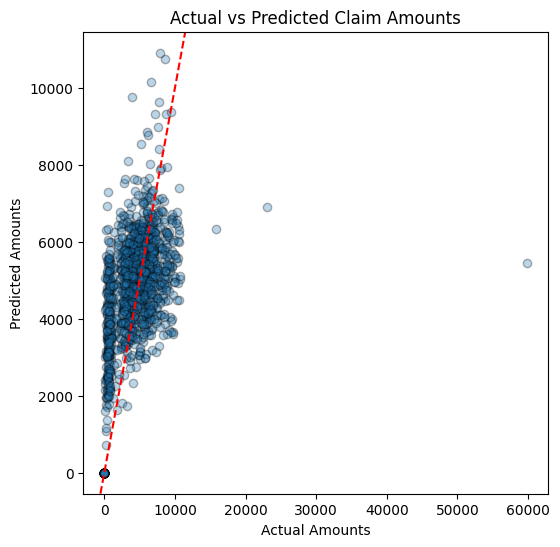

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(actual_amounts, predicted_amount_final, alpha=0.3, edgecolors='black')  # Lower alpha
plt.xlabel("Actual Amounts")
plt.ylabel("Predicted Amounts")
plt.title("Actual vs Predicted Claim Amounts")
plt.axline((0, 0), slope=1, color="red", linestyle="dashed")  # Perfect prediction line
plt.show()


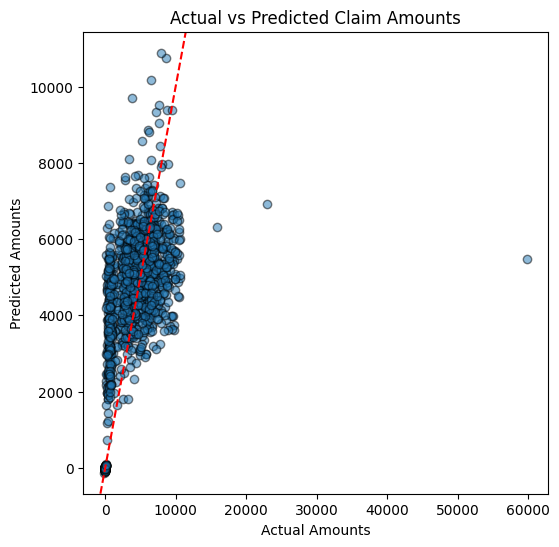

In [19]:
jitter = np.random.normal(0, 50, size=actual_amounts.shape)  # Adjust the spread

plt.figure(figsize=(6, 6))
plt.scatter(actual_amounts + jitter, predicted_amount_final + jitter, alpha=0.5, edgecolors='black')
plt.xlabel("Actual Amounts")
plt.ylabel("Predicted Amounts")
plt.title("Actual vs Predicted Claim Amounts")
plt.axline((0, 0), slope=1, color="red", linestyle="dashed")
plt.show()


In [20]:
# import pandas as pd
# import numpy as np
# import os

# # Define file paths
# governance_folder = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\governance"
# os.makedirs(governance_folder, exist_ok=True)  # Ensure folder exists

# save_path_csv = os.path.join(governance_folder, "new_model_performance.csv")
# save_path_pkl = os.path.join(governance_folder, "new_model_performance.pkl")

# # Create DataFrame with old model predictions
# governance_data = pd.DataFrame({
#     "True_Condition": condition_labels.flatten(),
#     "Predicted_Condition": predicted_condition_binary.flatten(),
#     "True_Amount": actual_amounts.flatten(),
#     "Predicted_Amount": predicted_amount_final.flatten(),
# })

# # Save as CSV & Pickle
# governance_data.to_csv(save_path_csv, index=False)
# governance_data.to_pickle(save_path_pkl)

# print(f"✅ Old model predictions saved to:\n- {save_path_csv}\n- {save_path_pkl}")
